# Customer Profile Segmentation & SHAP Explainability

This notebook segments customers into **4 uplift profiles** and uses **SHAP values** to explain why individual users belong to each segment.

## The 4 User Types in Uplift Modeling

| Profile | Treatment Effect | Description | Business Action |
|---------|------------------|-------------|------------------|
| **Persuadables** | High positive uplift | Convert *because of* treatment | ✅ Target these users! |
| **Sure Things** | Low uplift (already convert) | Convert regardless of treatment | ⚠️ Save marketing budget |
| **Lost Causes** | Low uplift (never convert) | Don't convert regardless | ⚠️ Don't waste resources |
| **Sleeping Dogs** | Negative uplift | Treatment *hurts* conversion | 🚫 Avoid treating! |

**Goal:** Identify Persuadables to maximize ROI, avoid Sleeping Dogs to prevent harm.


In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Plot settings
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 11

%matplotlib inline

print("✅ Libraries loaded successfully!")


✅ Libraries loaded successfully!


## 1. Load Saved Model and Data

We use the **T-Learner** model (best performer from notebook 02).


In [26]:
# Set up paths
project_root = Path('..').resolve()
models_dir = project_root / 'models'
viz_data_dir = project_root / 'visualizations' / 'data'

print(f"Project root: {project_root}")
print(f"Models directory: {models_dir}")


Project root: /Users/sivaguganjayachandran/cursor/criteo-uplift
Models directory: /Users/sivaguganjayachandran/cursor/criteo-uplift/models


In [27]:
# Load predictions from notebook 02 (for test set features and saved uplift predictions)
print("Loading saved predictions...")
predictions_df = pd.read_csv(viz_data_dir / 'nb02_predictions.csv')
print(f"✅ Loaded {len(predictions_df):,} samples")

# Extract data
feature_cols = [f'f{i}' for i in range(12)]
X_test = predictions_df[feature_cols].values
y_test = predictions_df['y_true'].values
t_test = predictions_df['treatment'].values
uplift_pred = predictions_df['uplift_t_learner'].values

print(f"\nFeatures shape: {X_test.shape}")
print(f"Uplift predictions range: [{uplift_pred.min():.4f}, {uplift_pred.max():.4f}]")

# Re-train T-Learner (joblib doesn't properly serialize XGBoost models from causalml)
print("\n" + "="*50)
print("Re-training T-Learner for SHAP analysis...")
print("="*50)

from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split

# Load from raw parquet (the CSV sample only has treatment=1)
data_dir = project_root / 'data' / 'raw'
print("Loading from parquet file...")
full_df = pd.read_parquet(data_dir / 'criteo_uplift.parquet')

# Create a balanced sample with both treatment and control groups
np.random.seed(42)
n_sample = 50000

control_df = full_df[full_df['treatment'] == 0].sample(n=min(n_sample, len(full_df[full_df['treatment'] == 0])), random_state=42)
treatment_df = full_df[full_df['treatment'] == 1].sample(n=n_sample, random_state=42)
sample_df = pd.concat([control_df, treatment_df], ignore_index=True)

print(f"Sampled dataset: {len(sample_df):,} samples")
print(f"  Control: {len(control_df):,}, Treatment: {len(treatment_df):,}")

# Prepare features and targets
X_full = sample_df[feature_cols].values
y_full = sample_df['conversion'].values
t_full = sample_df['treatment'].values

# Split data
X_train, X_test_new, y_train, y_test_new, t_train, t_test_new = train_test_split(
    X_full, y_full, t_full, test_size=0.3, random_state=42, stratify=t_full
)

print(f"Training set: {len(X_train):,} samples")
print(f"Test set: {len(X_test_new):,} samples")

# Create and train T-Learner components (control and treatment models)
# Note: base_score=0.5 is required for SHAP compatibility with newer XGBoost versions
class SimpleTLearner:
    """Simple T-Learner with accessible internal models for SHAP"""
    def __init__(self):
        self.model_c = XGBClassifier(
            n_estimators=100, max_depth=5, learning_rate=0.1,
            random_state=42, verbosity=0, use_label_encoder=False,
            base_score=0.5  # Required for SHAP compatibility
        )
        self.model_t = XGBClassifier(
            n_estimators=100, max_depth=5, learning_rate=0.1,
            random_state=42, verbosity=0, use_label_encoder=False,
            base_score=0.5  # Required for SHAP compatibility
        )
    
    def fit(self, X, y, t):
        # Split by treatment
        X_c, y_c = X[t == 0], y[t == 0]
        X_t, y_t = X[t == 1], y[t == 1]
        
        print(f"  Control group: {len(X_c):,} samples")
        print(f"  Treatment group: {len(X_t):,} samples")
        
        # Fit models
        self.model_c.fit(X_c, y_c)
        self.model_t.fit(X_t, y_t)
        return self
    
    def predict_uplift(self, X):
        prob_c = self.model_c.predict_proba(X)[:, 1]
        prob_t = self.model_t.predict_proba(X)[:, 1]
        return prob_t - prob_c

# Train T-Learner
t_learner = SimpleTLearner()
t_learner.fit(X_train, y_train, t_train)

# Verify predictions
uplift_new = t_learner.predict_uplift(X_test)
print(f"\n✅ T-Learner trained!")
print(f"   New uplift range: [{uplift_new.min():.4f}, {uplift_new.max():.4f}]")

Loading saved predictions...
✅ Loaded 90,000 samples

Features shape: (90000, 12)
Uplift predictions range: [-0.6561, 0.6524]

Re-training T-Learner for SHAP analysis...
Loading from parquet file...
Sampled dataset: 100,000 samples
  Control: 50,000, Treatment: 50,000
Training set: 70,000 samples
Test set: 30,000 samples
  Control group: 35,000 samples
  Treatment group: 35,000 samples

✅ T-Learner trained!
   New uplift range: [-0.6548, 0.7906]


## 2. Customer Profile Segmentation (Rule-Based)

We segment users using **absolute thresholds** based on uplift theory, NOT percentiles.

### Segmentation Rules (Order Matters!):

| Segment | Rule | Rationale |
|---------|------|-----------|
| **Sleeping Dogs** | Uplift < -0.5% | Treatment hurts - check first for safety |
| **Sure Things** | Baseline Prob > 50% | Will convert anyway - save budget |
| **Persuadables** | Uplift > 0.1% | Positive incremental value from treatment |
| **Lost Causes** | Everything else | Low or no uplift |


In [28]:
def segment_customers_rule_based(uplift_predictions, baseline_probs,
                                  uplift_threshold=0.001,     # 0.1% uplift
                                  baseline_sure_thing=0.50,   # 50% baseline
                                  sleeping_dog_threshold=-0.005):  # -0.5%
    """
    Rule-based customer segmentation using ABSOLUTE thresholds (not percentiles).
    
    Args:
        uplift_predictions: Array of predicted CATE values (τ = P(Y|T=1) - P(Y|T=0))
        baseline_probs: Array of P(Y=1|T=0) - conversion probability WITHOUT treatment
        uplift_threshold: Minimum uplift for "Persuadable" (default: 0.1%)
        baseline_sure_thing: Minimum baseline for "Sure Things" (default: 50%)
        sleeping_dog_threshold: Uplift below this = "Sleeping Dogs" (default: -0.5%)
    
    Returns:
        Array of segment labels
        
    Rule Order (MATTERS!):
        1. Sleeping Dogs: uplift < -0.5% (safety first - flag harmful treatments)
        2. Sure Things: baseline > 50% (save budget - they convert anyway)
        3. Persuadables: uplift > 0.1% (positive incremental value)
        4. Lost Causes: everything else
    """
    n = len(uplift_predictions)
    segments = np.empty(n, dtype=object)
    
    for i in range(n):
        uplift = uplift_predictions[i]
        baseline = baseline_probs[i]
        
        # Rule 1: Sleeping Dogs - treatment hurts (check first for safety)
        if uplift < sleeping_dog_threshold:
            segments[i] = 'Sleeping Dogs'
        
        # Rule 2: Sure Things - high baseline, will convert anyway
        elif baseline > baseline_sure_thing:
            segments[i] = 'Sure Things'
        
        # Rule 3: Persuadables - positive uplift from treatment
        elif uplift > uplift_threshold:
            segments[i] = 'Persuadables'
        
        # Rule 4: Lost Causes - everything else
        else:
            segments[i] = 'Lost Causes'
    
    return segments

print("✅ Rule-based segmentation function defined")
print("\nThresholds:")
print("   • Persuadables: uplift > 0.1%")
print("   • Sure Things: baseline_prob > 50%")
print("   • Sleeping Dogs: uplift < -0.5%")
print("   • Lost Causes: everything else")


✅ Rule-based segmentation function defined

Thresholds:
   • Persuadables: uplift > 0.1%
   • Sure Things: baseline_prob > 50%
   • Sleeping Dogs: uplift < -0.5%
   • Lost Causes: everything else


In [29]:
# Get baseline probabilities from the T-Learner's control model
print("Extracting baseline probabilities from T-Learner...")

# T-Learner has model_c (control model) and model_t (treatment model)
try:
    baseline_probs = t_learner.model_c.predict_proba(X_test)[:, 1]
    treatment_probs = t_learner.model_t.predict_proba(X_test)[:, 1]
    print(f"✅ Baseline probs range: [{baseline_probs.min():.4f}, {baseline_probs.max():.4f}]")
    print(f"✅ Treatment probs range: [{treatment_probs.min():.4f}, {treatment_probs.max():.4f}]")
except Exception as e:
    print(f"⚠️ Could not extract baseline probs: {e}")
    baseline_probs = None
    treatment_probs = None


Extracting baseline probabilities from T-Learner...
✅ Baseline probs range: [0.0000, 0.8104]
✅ Treatment probs range: [0.0001, 0.8724]


In [30]:
# Segment customers using RULE-BASED approach
print("Segmenting customers using rule-based thresholds...")
print("(NOT percentiles - using absolute business rules)\n")

# Apply rule-based segmentation
segments = segment_customers_rule_based(
    uplift_predictions=uplift_pred,
    baseline_probs=baseline_probs,
    uplift_threshold=0.001,       # 0.1% uplift
    baseline_sure_thing=0.50,     # 50% baseline for Sure Things
    sleeping_dog_threshold=-0.005 # -0.5% for Sleeping Dogs
)

# Add to dataframe
predictions_df['segment'] = segments
predictions_df['uplift_pred'] = uplift_pred
predictions_df['baseline_prob'] = baseline_probs
predictions_df['treatment_prob'] = treatment_probs

# Count segments
segment_counts = predictions_df['segment'].value_counts()
print("="*50)
print("CUSTOMER SEGMENT DISTRIBUTION (Rule-Based)")
print("="*50)
for seg, count in segment_counts.items():
    pct = count / len(predictions_df) * 100
    print(f"{seg}: {count:,} ({pct:.1f}%)")

print("\n📋 Thresholds Applied:")
print("   • Persuadables: uplift > 0.1%")
print("   • Sure Things: baseline_prob > 50%")
print("   • Sleeping Dogs: uplift < -0.5%")
print("   • Lost Causes: everything else")


Segmenting customers using rule-based thresholds...
(NOT percentiles - using absolute business rules)

CUSTOMER SEGMENT DISTRIBUTION (Rule-Based)
Lost Causes: 75,413 (83.8%)
Persuadables: 14,062 (15.6%)
Sleeping Dogs: 493 (0.5%)
Sure Things: 32 (0.0%)

📋 Thresholds Applied:
   • Persuadables: uplift > 0.1%
   • Sure Things: baseline_prob > 50%
   • Sleeping Dogs: uplift < -0.5%
   • Lost Causes: everything else


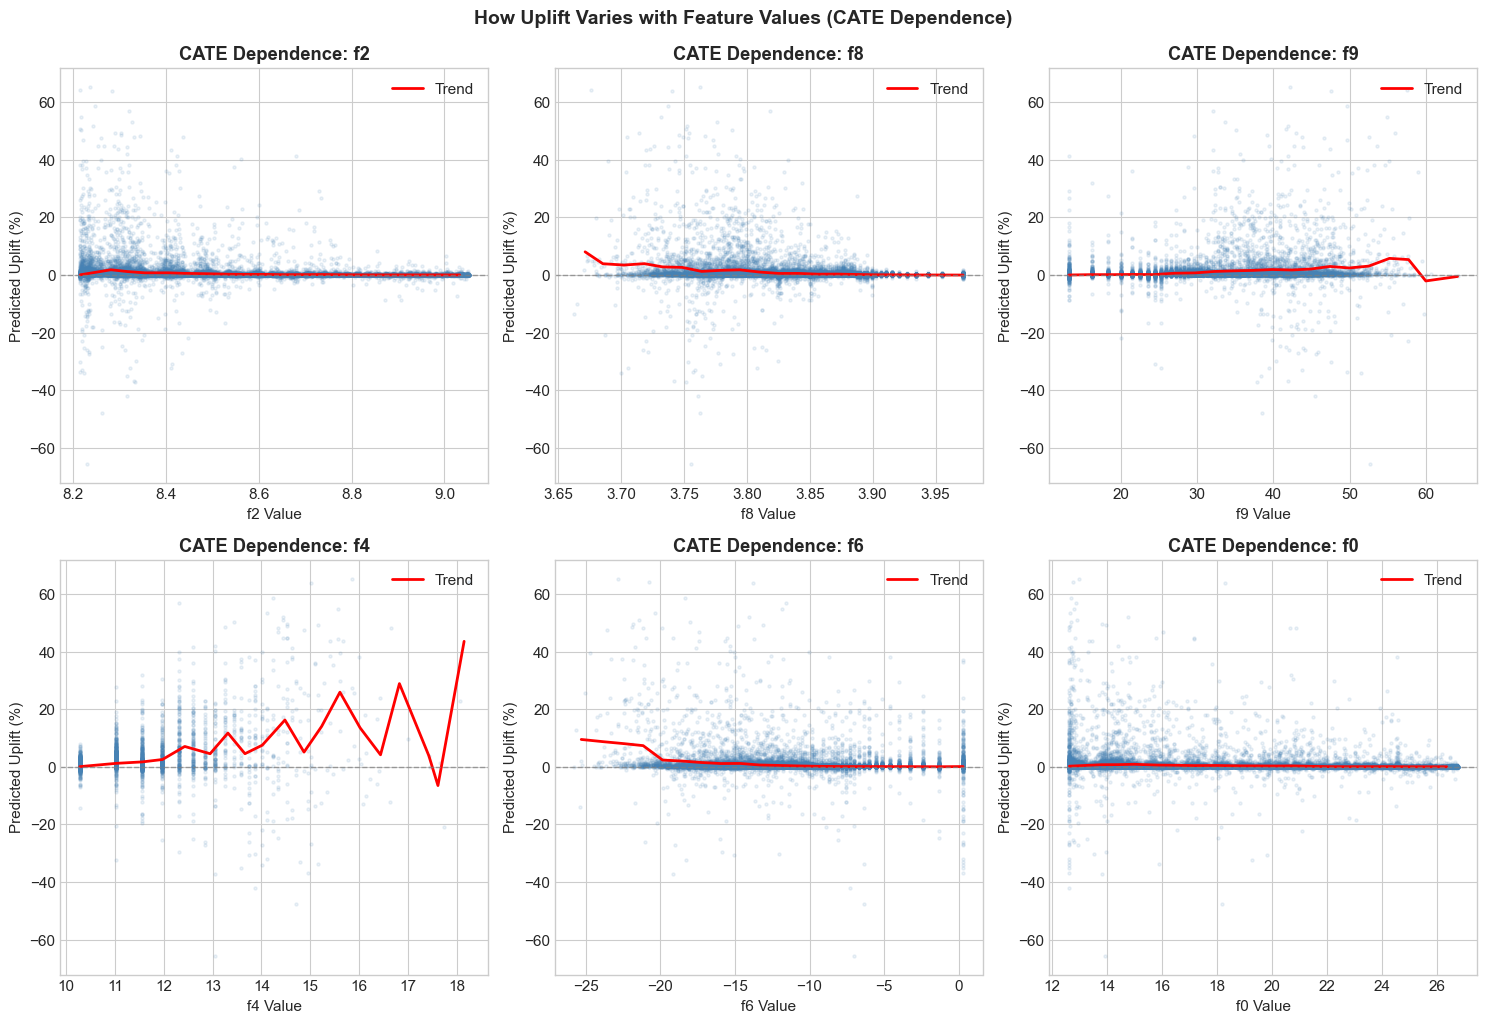

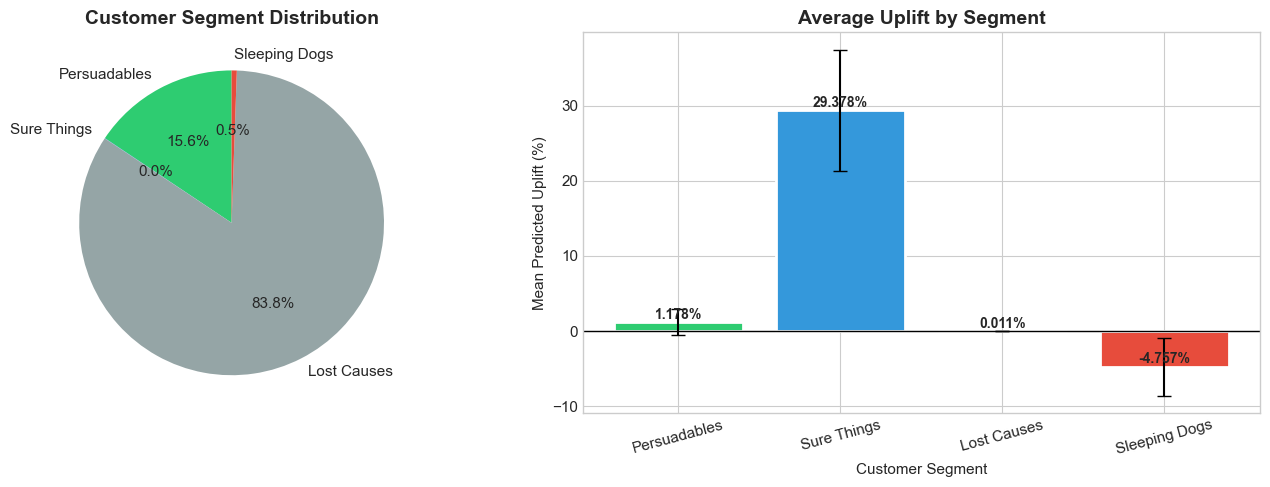

In [31]:
# Visualize segment distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Color mapping
colors = {
    'Persuadables': '#2ecc71',      # Green - target these!
    'Sure Things': '#3498db',        # Blue - already converting
    'Lost Causes': '#95a5a6',        # Gray - won't convert
    'Sleeping Dogs': '#e74c3c'       # Red - avoid!
}

# Pie chart
ax1 = axes[0]
segment_order = ['Persuadables', 'Sure Things', 'Lost Causes', 'Sleeping Dogs']
sizes = [segment_counts.get(s, 0) for s in segment_order]
pie_colors = [colors[s] for s in segment_order]

wedges, texts, autotexts = ax1.pie(sizes, labels=segment_order, colors=pie_colors,
                                    autopct='%1.1f%%', startangle=90,
                                    textprops={'fontsize': 11})
ax1.set_title('Customer Segment Distribution', fontsize=14, fontweight='bold')

# Bar chart with uplift
ax2 = axes[1]
segment_stats = predictions_df.groupby('segment')['uplift_pred'].agg(['mean', 'std', 'count'])
segment_stats = segment_stats.reindex(segment_order)

bars = ax2.bar(segment_order, segment_stats['mean'] * 100, 
               yerr=segment_stats['std'] * 100 / 2,
               color=[colors[s] for s in segment_order],
               capsize=5, edgecolor='white', linewidth=2)

ax2.axhline(y=0, color='black', linestyle='-', linewidth=1)
ax2.set_xlabel('Customer Segment')
ax2.set_ylabel('Mean Predicted Uplift (%)')
ax2.set_title('Average Uplift by Segment', fontsize=14, fontweight='bold')
ax2.tick_params(axis='x', rotation=15)

# Add value labels
for bar, mean in zip(bars, segment_stats['mean'] * 100):
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.05,
             f'{mean:.3f}%', ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()


In [32]:
# Detailed segment statistics
print("\n" + "="*70)
print("DETAILED SEGMENT STATISTICS")
print("="*70)

for segment in segment_order:
    seg_df = predictions_df[predictions_df['segment'] == segment]
    
    print(f"\n📊 {segment.upper()}")
    print(f"   Count: {len(seg_df):,} ({len(seg_df)/len(predictions_df)*100:.1f}%)")
    print(f"   Mean Uplift: {seg_df['uplift_pred'].mean()*100:.4f}%")
    print(f"   Uplift Range: [{seg_df['uplift_pred'].min()*100:.4f}%, {seg_df['uplift_pred'].max()*100:.4f}%]")
    
    if 'baseline_prob' in seg_df.columns:
        print(f"   Mean Baseline Prob: {seg_df['baseline_prob'].mean()*100:.4f}%")
    
    # Actual conversion rates
    treated = seg_df[seg_df['treatment'] == 1]
    control = seg_df[seg_df['treatment'] == 0]
    if len(treated) > 0 and len(control) > 0:
        actual_uplift = treated['y_true'].mean() - control['y_true'].mean()
        print(f"   Actual Uplift: {actual_uplift*100:.4f}%")



DETAILED SEGMENT STATISTICS

📊 PERSUADABLES
   Count: 14,062 (15.6%)
   Mean Uplift: 1.1782%
   Uplift Range: [0.1000%, 63.7531%]
   Mean Baseline Prob: 0.7575%
   Actual Uplift: 0.6603%

📊 SURE THINGS
   Count: 32 (0.0%)
   Mean Uplift: 29.3780%
   Uplift Range: [0.0516%, 65.2421%]
   Mean Baseline Prob: 62.3175%
   Actual Uplift: -19.2308%

📊 LOST CAUSES
   Count: 75,413 (83.8%)
   Mean Uplift: 0.0107%
   Uplift Range: [-0.4982%, 0.0999%]
   Mean Baseline Prob: 0.0364%
   Actual Uplift: 0.0080%

📊 SLEEPING DOGS
   Count: 493 (0.5%)
   Mean Uplift: -4.7573%
   Uplift Range: [-65.6058%, -0.5005%]
   Mean Baseline Prob: 3.2075%
   Actual Uplift: 0.8374%


## 3. SHAP Values for Explainability

**SHAP (SHapley Additive exPlanations)** explains:
- Which features contribute most to a user's predicted uplift
- Whether each feature pushes toward Persuadable or Sleeping Dog

We'll use SHAP on the T-Learner's component models.


In [33]:
# Import SHAP
try:
    import shap
    print("✅ SHAP library loaded")
except ImportError:
    print("⚠️ SHAP not installed. Installing...")
    import subprocess
    subprocess.check_call(['pip', 'install', 'shap'])
    import shap
    print("✅ SHAP installed and loaded")


✅ SHAP library loaded


In [34]:
# Create SHAP explainers for the T-Learner models
print("Creating SHAP explainers...")

# Use a smaller sample for SHAP (computational efficiency)
shap_sample_size = min(1000, len(X_test))
np.random.seed(42)
shap_idx = np.random.choice(len(X_test), shap_sample_size, replace=False)
X_shap = X_test[shap_idx]

print(f"Using {shap_sample_size} samples for SHAP analysis")

# Use model-agnostic SHAP (avoids XGBoost/SHAP version incompatibility)
# Create background dataset for SHAP
background_size = min(100, len(X_shap))
background = X_shap[:background_size]

print("Creating model-agnostic explainers...")

# Define prediction functions that return class 1 probability
def predict_control(X):
    return t_learner.model_c.predict_proba(X)[:, 1]

def predict_treatment(X):
    return t_learner.model_t.predict_proba(X)[:, 1]

# Use SHAP Explainer with automatic algorithm selection
explainer_c = shap.Explainer(predict_control, background, algorithm="auto")
explainer_t = shap.Explainer(predict_treatment, background, algorithm="auto")

print("\nCalculating SHAP values (this may take a moment)...")
shap_values_c = explainer_c(X_shap).values
shap_values_t = explainer_t(X_shap).values

# SHAP values for uplift = SHAP treatment - SHAP control
shap_values_uplift = shap_values_t - shap_values_c

print("✅ SHAP values calculated!")
print(f"   Control SHAP shape: {shap_values_c.shape}")
print(f"   Treatment SHAP shape: {shap_values_t.shape}")
print(f"   Uplift SHAP shape: {shap_values_uplift.shape}")

Creating SHAP explainers...
Using 1000 samples for SHAP analysis
Creating model-agnostic explainers...

Calculating SHAP values (this may take a moment)...


PermutationExplainer explainer: 1001it [00:12, 16.37it/s]                         
PermutationExplainer explainer: 1001it [00:12, 16.45it/s]                         

✅ SHAP values calculated!
   Control SHAP shape: (1000, 12)
   Treatment SHAP shape: (1000, 12)
   Uplift SHAP shape: (1000, 12)


In [35]:
# Global feature importance for uplift
print("\n" + "="*50)
print("GLOBAL FEATURE IMPORTANCE FOR UPLIFT")
print("="*50)

# Mean absolute SHAP values
mean_shap_uplift = np.abs(shap_values_uplift).mean(axis=0)
feature_importance = pd.DataFrame({
    'Feature': feature_cols,
    'Importance': mean_shap_uplift
}).sort_values('Importance', ascending=False)

print(feature_importance.to_string(index=False))



GLOBAL FEATURE IMPORTANCE FOR UPLIFT
Feature  Importance
     f8    0.000907
     f2    0.000899
     f9    0.000608
     f4    0.000537
     f6    0.000406
     f0    0.000353
    f10    0.000231
     f3    0.000188
     f7    0.000067
    f11    0.000061
     f5    0.000031
     f1    0.000010


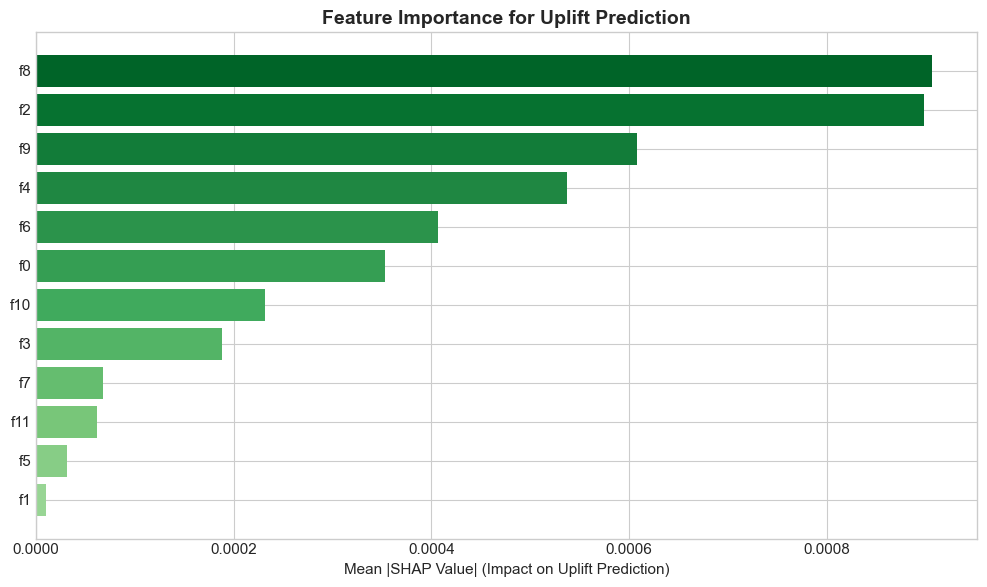

In [36]:
# Visualize global SHAP importance
fig, ax = plt.subplots(figsize=(10, 6))

colors_imp = plt.cm.Greens(np.linspace(0.4, 0.9, len(feature_importance)))[::-1]
bars = ax.barh(feature_importance['Feature'], feature_importance['Importance'],
               color=colors_imp)

ax.set_xlabel('Mean |SHAP Value| (Impact on Uplift Prediction)')
ax.set_title('Feature Importance for Uplift Prediction', fontsize=14, fontweight='bold')
ax.invert_yaxis()

plt.tight_layout()
plt.show()


## 4. Individual User Explanation

Let's pick a **random user** and explain:
1. Which segment they belong to
2. Their predicted uplift
3. **Why** they're in that segment (SHAP breakdown)


In [37]:
def explain_user(user_idx, X, predictions_df, shap_values_uplift, 
                 feature_names, shap_idx_mapping):
    """
    Generate a detailed explanation for a specific user.
    """
    user_data = predictions_df.iloc[user_idx]
    
    print("="*70)
    print(f"USER #{user_idx} - DETAILED PROFILE EXPLANATION")
    print("="*70)
    
    # Basic info
    print(f"\n📋 CLASSIFICATION: {user_data['segment']}")
    print(f"   Predicted Uplift: {user_data['uplift_pred']*100:.4f}%")
    
    if 'baseline_prob' in user_data:
        print(f"   Baseline Prob (without treatment): {user_data['baseline_prob']*100:.4f}%")
        print(f"   Treatment Prob (with treatment): {user_data['treatment_prob']*100:.4f}%")
    
    print(f"   Actual Treatment: {'Treated' if user_data['treatment'] == 1 else 'Control'}")
    print(f"   Actual Outcome: {'Converted' if user_data['y_true'] == 1 else 'Did not convert'}")
    
    # Segment-specific insight
    segment = user_data['segment']
    print(f"\n💡 WHAT THIS MEANS:")
    
    if segment == 'Persuadables':
        print("   This user has HIGH POSITIVE UPLIFT.")
        print("   → They are likely to convert BECAUSE of the treatment.")
        print("   → RECOMMENDATION: Target with marketing! 🎯")
    elif segment == 'Sleeping Dogs':
        print("   This user has NEGATIVE UPLIFT.")
        print("   → Treatment actually HURTS their conversion probability!")
        print("   → RECOMMENDATION: Do NOT target! 🚫")
    elif segment == 'Sure Things':
        print("   This user has LOW UPLIFT but HIGH baseline.")
        print("   → They would convert anyway, with or without treatment.")
        print("   → RECOMMENDATION: Save marketing budget. 💰")
    else:  # Lost Causes
        print("   This user has LOW UPLIFT and LOW baseline.")
        print("   → They won't convert regardless of treatment.")
        print("   → RECOMMENDATION: Don't waste resources. ⏭️")
    
    # Feature values
    print(f"\n📊 FEATURE VALUES:")
    for i, feat in enumerate(feature_names):
        print(f"   {feat}: {X[user_idx, i]:.4f}")
    
    # SHAP explanation if available
    if user_idx in shap_idx_mapping:
        shap_local_idx = shap_idx_mapping[user_idx]
        user_shap = shap_values_uplift[shap_local_idx]
        
        print(f"\n🔍 SHAP EXPLANATION (Why this uplift?):")
        
        # Sort by absolute impact
        shap_df = pd.DataFrame({
            'Feature': feature_names,
            'Value': X[user_idx],
            'SHAP': user_shap
        }).sort_values('SHAP', key=abs, ascending=False)
        
        print("\n   Top factors affecting this user's uplift:")
        for _, row in shap_df.head(5).iterrows():
            direction = "↑ increases" if row['SHAP'] > 0 else "↓ decreases"
            print(f"   • {row['Feature']} = {row['Value']:.4f} → {direction} uplift by {abs(row['SHAP'])*100:.4f}%")
        
        return user_shap
    else:
        print("\n⚠️ SHAP values not available for this user (not in SHAP sample)")
        return None

print("✅ User explanation function defined")


✅ User explanation function defined


In [38]:
# Create mapping from original index to SHAP sample index
shap_idx_mapping = {orig_idx: i for i, orig_idx in enumerate(shap_idx)}

# Pick a random user from each segment for demonstration
print("Selecting random users from each segment...\n")

np.random.seed(123)  # For reproducibility

for segment in ['Persuadables', 'Sleeping Dogs', 'Sure Things', 'Lost Causes']:
    seg_indices = predictions_df[predictions_df['segment'] == segment].index.tolist()
    
    # Try to find a user that's in our SHAP sample
    seg_in_shap = [idx for idx in seg_indices if idx in shap_idx_mapping]
    
    if seg_in_shap:
        user_idx = np.random.choice(seg_in_shap)
    else:
        user_idx = np.random.choice(seg_indices)
    
    explain_user(user_idx, X_test, predictions_df, shap_values_uplift, 
                 feature_cols, shap_idx_mapping)
    print("\n")


Selecting random users from each segment...

USER #68131 - DETAILED PROFILE EXPLANATION

📋 CLASSIFICATION: Persuadables
   Predicted Uplift: 0.1298%
   Baseline Prob (without treatment): 0.6953%
   Treatment Prob (with treatment): 0.5864%
   Actual Treatment: Treated
   Actual Outcome: Did not convert

💡 WHAT THIS MEANS:
   This user has HIGH POSITIVE UPLIFT.
   → They are likely to convert BECAUSE of the treatment.
   → RECOMMENDATION: Target with marketing! 🎯

📊 FEATURE VALUES:
   f0: 25.9631
   f1: 10.0597
   f2: 8.5885
   f3: 4.6799
   f4: 10.2805
   f5: 4.1155
   f6: -1.2882
   f7: 4.8338
   f8: 3.8275
   f9: 39.7036
   f10: 5.3004
   f11: -0.1687

🔍 SHAP EXPLANATION (Why this uplift?):

   Top factors affecting this user's uplift:
   • f8 = 3.8275 → ↓ decreases uplift by 0.3230%
   • f9 = 39.7036 → ↑ increases uplift by 0.2920%
   • f6 = -1.2882 → ↓ decreases uplift by 0.2303%
   • f0 = 25.9631 → ↑ increases uplift by 0.1919%
   • f4 = 10.2805 → ↓ decreases uplift by 0.0793%


US


SHAP WATERFALL PLOT: Visual Explanation

Showing SHAP waterfall for User #784 (Persuadable)
Predicted Uplift: 0.8018%


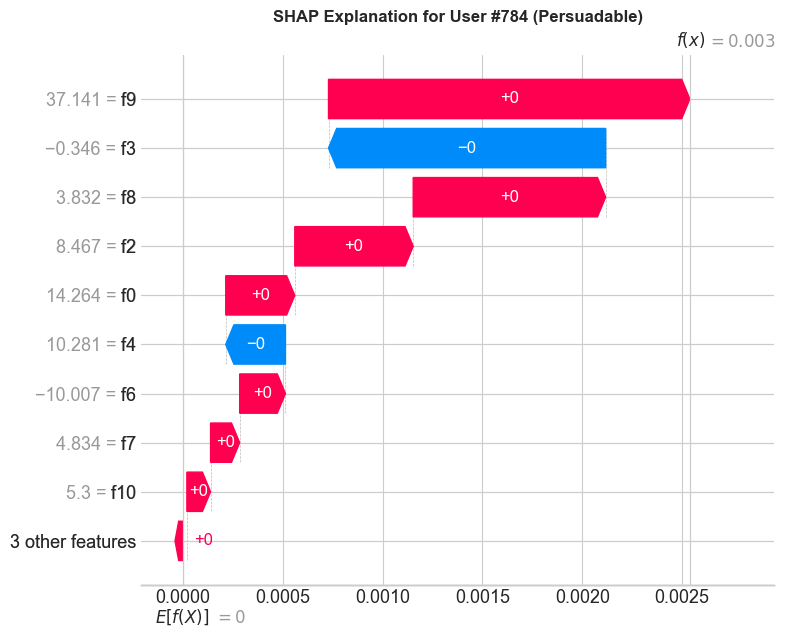

In [39]:
# SHAP waterfall plot for a Persuadable user
print("\n" + "="*50)
print("SHAP WATERFALL PLOT: Visual Explanation")
print("="*50)

# Pick a Persuadable user in our SHAP sample
persuadable_in_shap = [idx for idx in predictions_df[predictions_df['segment'] == 'Persuadables'].index 
                       if idx in shap_idx_mapping]

if persuadable_in_shap:
    example_idx = persuadable_in_shap[0]
    shap_local_idx = shap_idx_mapping[example_idx]
    
    print(f"\nShowing SHAP waterfall for User #{example_idx} (Persuadable)")
    print(f"Predicted Uplift: {predictions_df.iloc[example_idx]['uplift_pred']*100:.4f}%")
    
    # Create SHAP Explanation object for waterfall
    shap_explanation = shap.Explanation(
        values=shap_values_uplift[shap_local_idx],
        base_values=0,  # Base is 0 uplift
        data=X_shap[shap_local_idx],
        feature_names=feature_cols
    )
    
    plt.figure(figsize=(10, 6))
    shap.plots.waterfall(shap_explanation, show=False)
    plt.title(f'SHAP Explanation for User #{example_idx} (Persuadable)', fontsize=12, fontweight='bold')
    plt.tight_layout()
    plt.show()
else:
    print("No Persuadable users in SHAP sample")



COMPARISON: Persuadable vs Sleeping Dog


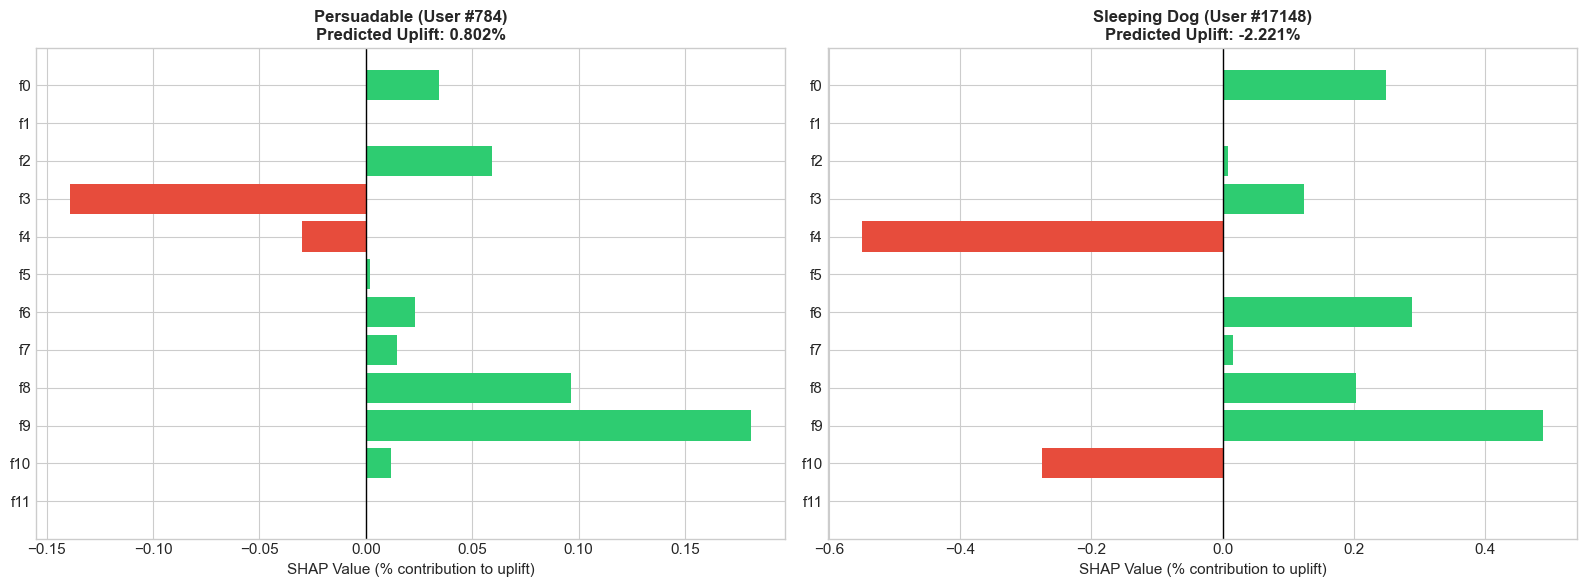


💡 Interpretation:
   Green bars → Feature pushes toward HIGHER uplift (Persuadable direction)
   Red bars → Feature pushes toward LOWER/NEGATIVE uplift (Sleeping Dog direction)


In [40]:
# Compare SHAP for a Persuadable vs Sleeping Dog
print("\n" + "="*60)
print("COMPARISON: Persuadable vs Sleeping Dog")
print("="*60)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Persuadable
if persuadable_in_shap:
    pers_idx = persuadable_in_shap[0]
    pers_shap_idx = shap_idx_mapping[pers_idx]
    
    ax1 = axes[0]
    y_pos = np.arange(len(feature_cols))
    shap_vals = shap_values_uplift[pers_shap_idx]
    colors_shap = ['#2ecc71' if v > 0 else '#e74c3c' for v in shap_vals]
    
    ax1.barh(y_pos, shap_vals * 100, color=colors_shap)
    ax1.set_yticks(y_pos)
    ax1.set_yticklabels(feature_cols)
    ax1.set_xlabel('SHAP Value (% contribution to uplift)')
    ax1.set_title(f'Persuadable (User #{pers_idx})\nPredicted Uplift: {predictions_df.iloc[pers_idx]["uplift_pred"]*100:.3f}%',
                  fontsize=12, fontweight='bold')
    ax1.axvline(x=0, color='black', linewidth=1)
    ax1.invert_yaxis()

# Sleeping Dog
sleeping_in_shap = [idx for idx in predictions_df[predictions_df['segment'] == 'Sleeping Dogs'].index 
                    if idx in shap_idx_mapping]

if sleeping_in_shap:
    sleep_idx = sleeping_in_shap[0]
    sleep_shap_idx = shap_idx_mapping[sleep_idx]
    
    ax2 = axes[1]
    shap_vals = shap_values_uplift[sleep_shap_idx]
    colors_shap = ['#2ecc71' if v > 0 else '#e74c3c' for v in shap_vals]
    
    ax2.barh(y_pos, shap_vals * 100, color=colors_shap)
    ax2.set_yticks(y_pos)
    ax2.set_yticklabels(feature_cols)
    ax2.set_xlabel('SHAP Value (% contribution to uplift)')
    ax2.set_title(f'Sleeping Dog (User #{sleep_idx})\nPredicted Uplift: {predictions_df.iloc[sleep_idx]["uplift_pred"]*100:.3f}%',
                  fontsize=12, fontweight='bold')
    ax2.axvline(x=0, color='black', linewidth=1)
    ax2.invert_yaxis()

plt.tight_layout()
plt.show()

print("\n💡 Interpretation:")
print("   Green bars → Feature pushes toward HIGHER uplift (Persuadable direction)")
print("   Red bars → Feature pushes toward LOWER/NEGATIVE uplift (Sleeping Dog direction)")


## 5. Interactive User Lookup

Function to look up any user by index or pick a random one.


In [41]:
def lookup_user(user_id=None):
    """
    Look up a specific user or pick a random one.
    """
    if user_id is None:
        user_id = np.random.randint(0, len(predictions_df))
        print(f"🎲 Randomly selected User #{user_id}")
    
    if user_id < 0 or user_id >= len(predictions_df):
        print(f"❌ Invalid user ID. Must be between 0 and {len(predictions_df)-1}")
        return
    
    user_shap = explain_user(user_id, X_test, predictions_df, shap_values_uplift, 
                              feature_cols, shap_idx_mapping)
    
    # Plot if SHAP available
    if user_shap is not None:
        fig, ax = plt.subplots(figsize=(10, 5))
        y_pos = np.arange(len(feature_cols))
        colors_shap = ['#2ecc71' if v > 0 else '#e74c3c' for v in user_shap]
        
        ax.barh(y_pos, user_shap * 100, color=colors_shap)
        ax.set_yticks(y_pos)
        ax.set_yticklabels(feature_cols)
        ax.set_xlabel('SHAP Value (% contribution to uplift)')
        ax.set_title(f'SHAP Breakdown for User #{user_id}', fontsize=12, fontweight='bold')
        ax.axvline(x=0, color='black', linewidth=1)
        ax.invert_yaxis()
        plt.tight_layout()
        plt.show()

# Example: Look up a random user
print("\n" + "="*70)
print("RANDOM USER LOOKUP")
print("="*70)
lookup_user()



RANDOM USER LOOKUP
🎲 Randomly selected User #63206
USER #63206 - DETAILED PROFILE EXPLANATION

📋 CLASSIFICATION: Persuadables
   Predicted Uplift: 0.1185%
   Baseline Prob (without treatment): 0.0208%
   Treatment Prob (with treatment): 0.3626%
   Actual Treatment: Treated
   Actual Outcome: Did not convert

💡 WHAT THIS MEANS:
   This user has HIGH POSITIVE UPLIFT.
   → They are likely to convert BECAUSE of the treatment.
   → RECOMMENDATION: Target with marketing! 🎯

📊 FEATURE VALUES:
   f0: 12.6164
   f1: 10.0597
   f2: 8.2972
   f3: 4.6799
   f4: 10.2805
   f5: 4.1155
   f6: 0.2944
   f7: 4.8338
   f8: 3.9437
   f9: 18.3801
   f10: 5.3004
   f11: -0.1687

⚠️ SHAP values not available for this user (not in SHAP sample)


In [42]:
# Try another random user
print("\n" + "="*70)
print("ANOTHER RANDOM USER")
print("="*70)
lookup_user()



ANOTHER RANDOM USER
🎲 Randomly selected User #15377
USER #15377 - DETAILED PROFILE EXPLANATION

📋 CLASSIFICATION: Lost Causes
   Predicted Uplift: -0.0008%
   Baseline Prob (without treatment): 0.0059%
   Treatment Prob (with treatment): 0.0067%
   Actual Treatment: Treated
   Actual Outcome: Did not convert

💡 WHAT THIS MEANS:
   This user has LOW UPLIFT and LOW baseline.
   → They won't convert regardless of treatment.
   → RECOMMENDATION: Don't waste resources. ⏭️

📊 FEATURE VALUES:
   f0: 25.7574
   f1: 10.0597
   f2: 8.2144
   f3: 4.6799
   f4: 10.2805
   f5: 4.1155
   f6: -3.2821
   f7: 4.8338
   f8: 3.9719
   f9: 13.1901
   f10: 5.3004
   f11: -0.1687

⚠️ SHAP values not available for this user (not in SHAP sample)


## 6. Summary & Key Takeaways


In [43]:
# Final summary
print("="*70)
print("CUSTOMER PROFILE SEGMENTATION - SUMMARY")
print("="*70)

print("\n📊 Segment Distribution:")
for segment in segment_order:
    count = segment_counts.get(segment, 0)
    pct = count / len(predictions_df) * 100
    emoji = {'Persuadables': '✅', 'Sure Things': '💰', 'Lost Causes': '⏭️', 'Sleeping Dogs': '🚫'}[segment]
    print(f"   {emoji} {segment}: {count:,} ({pct:.1f}%)")

print("\n🎯 Business Recommendations:")
print("   1. Focus marketing on PERSUADABLES - highest ROI potential")
print("   2. Avoid treating SLEEPING DOGS - treatment hurts conversion")
print("   3. Save budget on SURE THINGS - they'll convert anyway")
print("   4. Don't waste resources on LOST CAUSES - low potential")

print("\n📈 Top Features Driving Uplift (SHAP Importance):")
for i, (_, row) in enumerate(feature_importance.head(5).iterrows()):
    print(f"   {i+1}. {row['Feature']}: {row['Importance']:.6f}")


CUSTOMER PROFILE SEGMENTATION - SUMMARY

📊 Segment Distribution:
   ✅ Persuadables: 14,062 (15.6%)
   💰 Sure Things: 32 (0.0%)
   ⏭️ Lost Causes: 75,413 (83.8%)
   🚫 Sleeping Dogs: 493 (0.5%)

🎯 Business Recommendations:
   1. Focus marketing on PERSUADABLES - highest ROI potential
   2. Avoid treating SLEEPING DOGS - treatment hurts conversion
   3. Save budget on SURE THINGS - they'll convert anyway
   4. Don't waste resources on LOST CAUSES - low potential

📈 Top Features Driving Uplift (SHAP Importance):
   1. f8: 0.000907
   2. f2: 0.000899
   3. f9: 0.000608
   4. f4: 0.000537
   5. f6: 0.000406


## 5. CATE Dependence Plots

**CATE Dependence Plots** show how the treatment effect (uplift) varies with feature values.

This answers: *"For which users does the treatment work best?"*

- **Positive slope:** Higher feature values → higher uplift → more responsive to treatment
- **Negative slope:** Higher feature values → lower uplift → less responsive
- **Flat line:** Feature doesn't affect treatment response

Creating CATE Dependence Plots...
Top features: ['f8', 'f2', 'f9', 'f4', 'f6', 'f0']


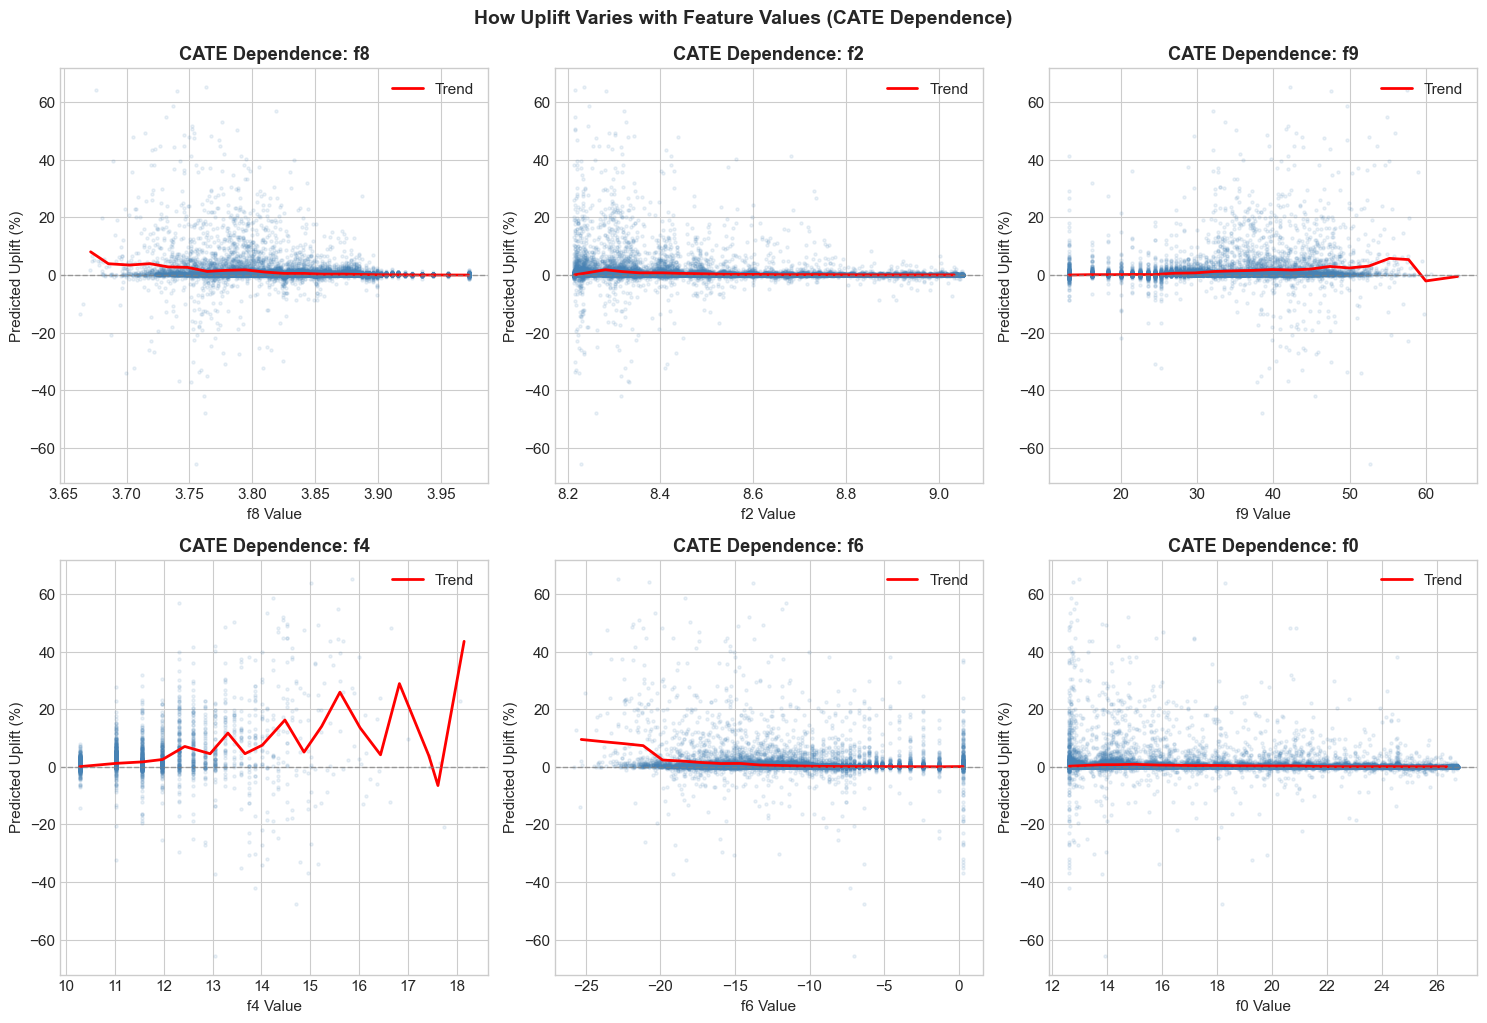


✅ CATE Dependence plots created!


In [44]:
# CATE Dependence Plots: How uplift varies with each feature

print("Creating CATE Dependence Plots...")
print("="*60)

# Get uplift predictions for our test set
uplift_for_plot = predictions_df['uplift_pred'].values
X_for_plot = predictions_df[feature_cols].values

# Get top 6 most important features (from SHAP analysis)
top_features = feature_importance['Feature'].head(6).tolist()
print(f"Top features: {top_features}")

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for idx, feature in enumerate(top_features):
    ax = axes[idx]
    feature_idx = feature_cols.index(feature)
    feature_values = X_for_plot[:, feature_idx]
    
    # Scatter plot with transparency
    ax.scatter(feature_values, uplift_for_plot * 100, 
               alpha=0.1, s=5, c='steelblue')
    
    # Add trend line (using binned means)
    n_bins = 20
    bins = pd.cut(feature_values, bins=n_bins)
    bin_means = pd.DataFrame({'feature': feature_values, 'uplift': uplift_for_plot * 100})
    bin_means['bin'] = bins
    trend = bin_means.groupby('bin', observed=True).agg({
        'feature': 'mean',
        'uplift': 'mean'
    }).dropna()
    
    ax.plot(trend['feature'], trend['uplift'], 
            color='red', linewidth=2, label='Trend')
    
    # Add zero line
    ax.axhline(y=0, color='gray', linestyle='--', linewidth=1, alpha=0.7)
    
    ax.set_xlabel(f'{feature} Value')
    ax.set_ylabel('Predicted Uplift (%)')
    ax.set_title(f'CATE Dependence: {feature}', fontweight='bold')
    ax.legend(loc='upper right')

plt.tight_layout()
plt.suptitle('How Uplift Varies with Feature Values (CATE Dependence)', 
             fontsize=14, fontweight='bold', y=1.02)
plt.show()

print("\n✅ CATE Dependence plots created!")

### SHAP Dependence Plots

SHAP dependence plots show how each feature's **contribution to the uplift prediction** varies with its value.

The color represents another feature, revealing **interaction effects**.

Creating SHAP-style Dependence Plots...
Computing feature contributions to uplift...
Feature contributions computed for 5,000 samples


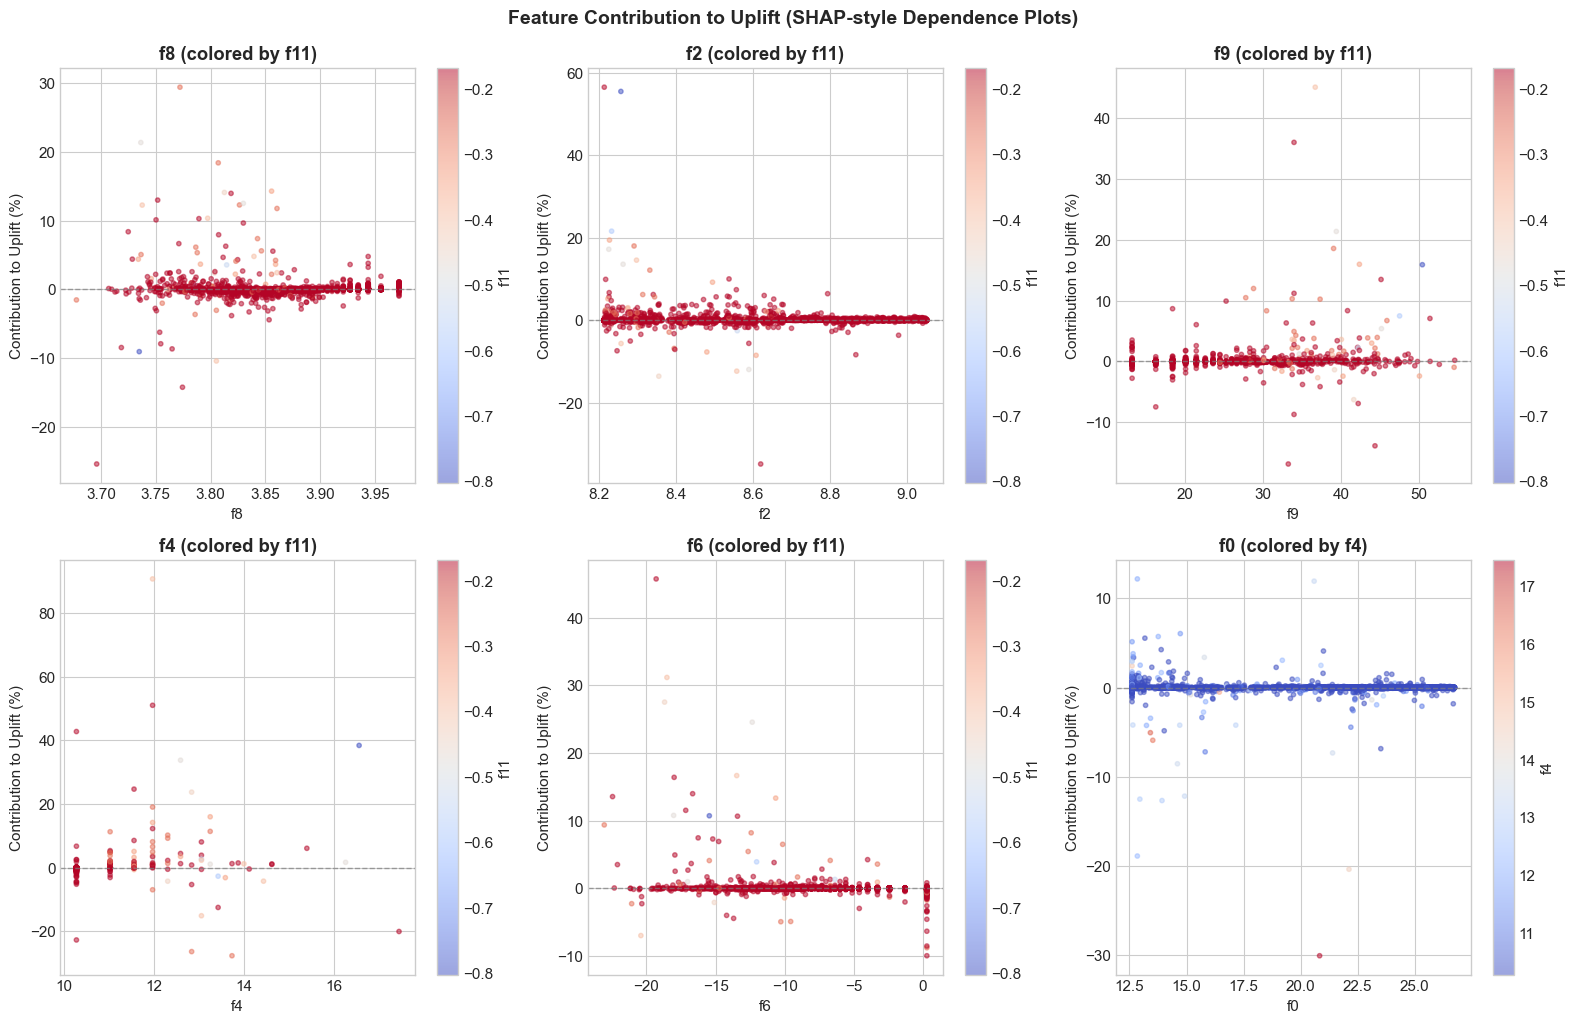


✅ SHAP-style Dependence plots created!


In [45]:
# SHAP Dependence Plots - Manual Implementation
# (Avoids SHAP library compatibility issues with XGBoost)

print("Creating SHAP-style Dependence Plots...")
print("="*60)

# Use a sample for speed
sample_size = 5000
np.random.seed(42)
sample_idx = np.random.choice(len(X_test_new), size=min(sample_size, len(X_test_new)), replace=False)
X_sample = X_test_new[sample_idx]

# Calculate approximate SHAP values using permutation importance approach
# For each feature, measure how much removing it changes the uplift prediction
print("Computing feature contributions to uplift...")

def get_feature_contributions(model_t, model_c, X, feature_cols):
    """
    Approximate SHAP-like contributions by measuring prediction change
    when each feature is permuted (replaced with random values).
    """
    n_samples, n_features = X.shape
    contributions = np.zeros((n_samples, n_features))
    
    # Get base predictions
    base_uplift = model_t.predict_proba(X)[:, 1] - model_c.predict_proba(X)[:, 1]
    
    for feat_idx in range(n_features):
        # Create permuted version (shuffle this feature)
        X_permuted = X.copy()
        np.random.shuffle(X_permuted[:, feat_idx])
        
        # Get predictions with permuted feature
        permuted_uplift = model_t.predict_proba(X_permuted)[:, 1] - model_c.predict_proba(X_permuted)[:, 1]
        
        # Contribution = how much prediction changes when feature is permuted
        contributions[:, feat_idx] = base_uplift - permuted_uplift
    
    return contributions

contributions = get_feature_contributions(t_learner.model_t, t_learner.model_c, X_sample, feature_cols)
print(f"Feature contributions computed for {len(X_sample):,} samples")

# Create dependence plots for top features
fig, axes = plt.subplots(2, 3, figsize=(16, 10))
axes = axes.flatten()

for idx, feature in enumerate(top_features):
    ax = axes[idx]
    feature_idx = feature_cols.index(feature)
    
    feature_values = X_sample[:, feature_idx]
    feature_contributions = contributions[:, feature_idx]
    
    # Find best interaction feature (highest correlation)
    other_features = [i for i in range(len(feature_cols)) if i != feature_idx]
    best_interaction_idx = feature_idx
    best_corr = 0
    for other_idx in other_features:
        corr = np.abs(np.corrcoef(X_sample[:, other_idx], feature_contributions)[0, 1])
        if not np.isnan(corr) and corr > best_corr:
            best_corr = corr
            best_interaction_idx = other_idx
    
    # Plot with color showing interaction
    scatter = ax.scatter(
        feature_values, 
        feature_contributions * 100,  # Convert to percentage
        c=X_sample[:, best_interaction_idx],
        cmap='coolwarm',
        alpha=0.5,
        s=10
    )
    ax.axhline(y=0, color='gray', linestyle='--', linewidth=1, alpha=0.7)
    ax.set_xlabel(f'{feature}')
    ax.set_ylabel('Contribution to Uplift (%)')
    ax.set_title(f'{feature} (colored by {feature_cols[best_interaction_idx]})', fontweight='bold')
    plt.colorbar(scatter, ax=ax, label=feature_cols[best_interaction_idx])

plt.tight_layout()
plt.suptitle('Feature Contribution to Uplift (SHAP-style Dependence Plots)', 
             fontsize=14, fontweight='bold', y=1.02)
plt.show()

print("\n✅ SHAP-style Dependence plots created!")

### Interpreting Dependence Plots

**What to look for:**

1. **Slope direction:**
   - Upward slope → Higher feature values = more responsive to treatment
   - Downward slope → Higher feature values = less responsive
   
2. **Spread/variance:**
   - Wide spread at certain values → Other features also matter (interactions)
   - Tight trend → Feature alone drives the effect

3. **Threshold effects:**
   - Sharp changes in slope may indicate natural cutoff points for segmentation

**Business application:**
These plots help answer: *"What characteristics make a user more/less responsive to our marketing?"*

In [48]:
# Save CATE Dependence Plot as image
print("Saving CATE Dependence Plot...")

# Ensure path is defined
viz_images_dir = project_root / 'visualizations' / 'images'
viz_images_dir.mkdir(parents=True, exist_ok=True)

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for idx, feature in enumerate(top_features):
    ax = axes[idx]
    feature_idx = feature_cols.index(feature)
    feature_values = X_for_plot[:, feature_idx]
    
    ax.scatter(feature_values, uplift_for_plot * 100, 
               alpha=0.1, s=5, c='steelblue')
    
    n_bins = 20
    bins = pd.cut(feature_values, bins=n_bins)
    bin_means = pd.DataFrame({'feature': feature_values, 'uplift': uplift_for_plot * 100})
    bin_means['bin'] = bins
    trend = bin_means.groupby('bin', observed=True).agg({
        'feature': 'mean',
        'uplift': 'mean'
    }).dropna()
    
    ax.plot(trend['feature'], trend['uplift'], 
            color='red', linewidth=2, label='Trend')
    ax.axhline(y=0, color='gray', linestyle='--', linewidth=1, alpha=0.7)
    ax.set_xlabel(f'{feature} Value')
    ax.set_ylabel('Predicted Uplift (%)')
    ax.set_title(f'CATE Dependence: {feature}', fontweight='bold')
    ax.legend(loc='upper right')

plt.tight_layout()
plt.suptitle('How Uplift Varies with Feature Values (CATE Dependence)', 
             fontsize=14, fontweight='bold', y=1.02)
plt.savefig(viz_images_dir / 'nb05_cate_dependence.png', dpi=150, bbox_inches='tight')
plt.close()
print("✅ Saved: nb05_cate_dependence.png")

Saving CATE Dependence Plot...
✅ Saved: nb05_cate_dependence.png


---

## 🚀 Production Pipeline: Save Artifacts


In [ ]:
# Save customer segments and SHAP data
print("Saving customer profile artifacts...")

viz_images_dir = project_root / 'visualizations' / 'images'
viz_images_dir.mkdir(parents=True, exist_ok=True)

# Save segment data
segment_summary = pd.DataFrame({
    'Segment': segment_order,
    'Count': [segment_counts.get(s, 0) for s in segment_order],
    'Percentage': [segment_counts.get(s, 0) / len(predictions_df) * 100 for s in segment_order],
    'Mean_Uplift': [predictions_df[predictions_df['segment'] == s]['uplift_pred'].mean() * 100 for s in segment_order]
})
segment_summary.to_csv(viz_data_dir / 'nb05_customer_segments.csv', index=False)
print("✅ Segment summary saved: nb05_customer_segments.csv")

# Save feature importance
feature_importance.to_csv(viz_data_dir / 'nb05_shap_importance.csv', index=False)
print("✅ SHAP importance saved: nb05_shap_importance.csv")

# Save full predictions with segments
predictions_df.to_csv(viz_data_dir / 'nb05_predictions_with_segments.csv', index=False)
print("✅ Full predictions with segments saved: nb05_predictions_with_segments.csv")


Saving customer profile artifacts...
✅ Segment summary saved: nb05_customer_segments.csv
✅ SHAP importance saved: nb05_shap_importance.csv
✅ Full predictions with segments saved: nb05_predictions_with_segments.csv


In [ ]:
# Save visualizations
print("\nSaving visualization images...")

# Segment distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

ax1 = axes[0]
sizes = [segment_counts.get(s, 0) for s in segment_order]
pie_colors = [colors[s] for s in segment_order]
ax1.pie(sizes, labels=segment_order, colors=pie_colors, autopct='%1.1f%%', startangle=90)
ax1.set_title('Customer Segment Distribution', fontsize=14, fontweight='bold')

ax2 = axes[1]
segment_stats = predictions_df.groupby('segment')['uplift_pred'].mean().reindex(segment_order) * 100
bars = ax2.bar(segment_order, segment_stats, color=[colors[s] for s in segment_order])
ax2.axhline(y=0, color='black', linestyle='-', linewidth=1)
ax2.set_ylabel('Mean Predicted Uplift (%)')
ax2.set_title('Average Uplift by Segment', fontsize=14, fontweight='bold')
ax2.tick_params(axis='x', rotation=15)

plt.tight_layout()
plt.savefig(viz_images_dir / 'nb05_segment_distribution.png', dpi=150, bbox_inches='tight')
plt.close()
print("✅ Saved: nb05_segment_distribution.png")

# SHAP importance
fig, ax = plt.subplots(figsize=(10, 6))
colors_imp = plt.cm.Greens(np.linspace(0.4, 0.9, len(feature_importance)))[::-1]
ax.barh(feature_importance['Feature'], feature_importance['Importance'], color=colors_imp)
ax.set_xlabel('Mean |SHAP Value|')
ax.set_title('Feature Importance for Uplift (SHAP)', fontsize=14, fontweight='bold')
ax.invert_yaxis()
plt.tight_layout()
plt.savefig(viz_images_dir / 'nb05_shap_importance.png', dpi=150, bbox_inches='tight')
plt.close()
print("✅ Saved: nb05_shap_importance.png")

print("\n" + "="*60)
print("✅ ALL NOTEBOOK 05 ARTIFACTS SAVED!")
print("="*60)



Saving visualization images...
✅ Saved: nb05_segment_distribution.png
✅ Saved: nb05_shap_importance.png

✅ ALL NOTEBOOK 05 ARTIFACTS SAVED!
